In [1]:
%%HTML
<style type="text/css">
div.h1 {
    background-color:#eebbcb; 
    color: white; 
    padding: 8px; 
    padding-right: 300px; 
    font-size: 35px; 
    max-width: 1500px; 
    margin: auto; 
    margin-top: 50px;
}

div.h2 {
    background-color:#2ca9e1; 
    color: white; 
    padding: 8px; 
    padding-right: 300px; 
    font-size: 35px; 
    max-width: 1500px; 
    margin: auto; 
    margin-top: 50px;
}
</style>

# <div class="h1">INGV - Volcanic Eruption Prediction</div>

![Volcano](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/Volcano_q.jpg/440px-Volcano_q.jpg)


## **Content**
1. [Introduction](#1)
1. [Libraries and dataset](#2)
1. [Data overview](#3)
1. [Visualization](#4)
   - Train data
   - Sensor data
1. [EDA](#5)
   - Trends between max of each sensor data and time_to_eruption.
   - Trends between minimum of each sensor data and time_to_eruption.
   - Trends between mean of each sensor data and time_to_eruption.
   - Trends between variance of each sensor data and time_to_eruption.
   - Trends 75, 95 and 99 percentiles of each sensor data and time_to_eruption.
   - Trends between count of outlier of each sensor data and time_to_eruption.
   - Sensor down time.
1. [Application to prediction](#6)

## **Summary**

1. Checked overview of given data.

1. Checked trends of segments which as large or small(especially smaller than 10 min) time_to_eruption by plots.

1. Visualized relation between descriptive statistics values and time_to_eruption. Especially,

  - In small time_to_eruption area (~ 1.0 * 10^7), descriptive statistics value such as variance get larger. 

  - In large time_to_eruption area (5.0 * 10^7 ~ ), sensor9 has large outlier count at some segment.

  - In medium time_to_eruption area (2.0 * 10^7 ~ 4.0 * 10^7), sensor6 tend to have slightly large parcentile(95% and 99%) value.
  
1. Applied found feature for baseline notebook and confirmed improvement(lb score 6614776 -> 6555212.).

<a id="1"></a> <br>
# <div class="alert alert-block alert-info">Introduction</div>

Detecting volcanic eruptions before they happen is an important problem that has historically proven to be a very difficult. This is because once an eruption occurs, it can cause extensive damage for many people. 

In this competition, we have to find the way for long-term predictions of the next volcanic eruptions. We need to have an in-depth understanding of the trends of data points, no matter how close or far away from each eruption.

In this notebook, I'll check given data, and do visualization and eda to get good understanding and insight for the data.

### premise from discussion

I think there are some ambiguity information for given data, but some important points have been made clear in the discussion. Here's a summary of what I've picked up.

- One volcano (https://www.kaggle.com/c/predict-volcanic-eruptions-ingv-oe/discussion/190936)

- Same 10 sensors (https://www.kaggle.com/c/predict-volcanic-eruptions-ingv-oe/discussion/191445)

- unit of time_to_eruption and time span of sensor data records are 0.01s. (https://www.kaggle.com/c/predict-volcanic-eruptions-ingv-oe/discussion/190682)

- Sensor has downtime(https://www.kaggle.com/c/predict-volcanic-eruptions-ingv-oe/discussion/191444).

<a id="2"></a> <br>
# <div class="alert alert-block alert-info">Libraries and dataset</div>

In [2]:
import gc
import glob
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tqdm import tqdm
import seaborn as sns

There are three kind of files.

- train.csv:  trainig data witch includes segment_id and time_to_eruption.

- sample_submission.csv: sample submission file witch includes segment_id and time_to_eruption all 0.

- [train|test]/*.csv: File which contains ten minutes of logs from ten different sensors arrayed around a volcano.

We have to predict "time_to_eruption" of sample_submission.

In [3]:
!ls ../input/predict-volcanic-eruptions-ingv-oe/

sample_submission.csv  test  train  train.csv


Let's load train data and sample_submission.

In [4]:
train = pd.read_csv("../input/predict-volcanic-eruptions-ingv-oe/train.csv")
sample_submission = pd.read_csv("../input/predict-volcanic-eruptions-ingv-oe/sample_submission.csv")

Second, check what sensor data is available. Sensor data named by "segment_id" + ".csv".

There are no data which taken in same segment.

In [5]:
segment_csvs = glob.glob("../input/predict-volcanic-eruptions-ingv-oe/train/*")
segment_csvs_test = glob.glob("../input/predict-volcanic-eruptions-ingv-oe/test/*")

In [6]:
segment_csvs[0:10]

['../input/predict-volcanic-eruptions-ingv-oe/train/2037160701.csv',
 '../input/predict-volcanic-eruptions-ingv-oe/train/1238398453.csv',
 '../input/predict-volcanic-eruptions-ingv-oe/train/1894979055.csv',
 '../input/predict-volcanic-eruptions-ingv-oe/train/621561921.csv',
 '../input/predict-volcanic-eruptions-ingv-oe/train/310353509.csv',
 '../input/predict-volcanic-eruptions-ingv-oe/train/1836010798.csv',
 '../input/predict-volcanic-eruptions-ingv-oe/train/213439290.csv',
 '../input/predict-volcanic-eruptions-ingv-oe/train/637677312.csv',
 '../input/predict-volcanic-eruptions-ingv-oe/train/350119945.csv',
 '../input/predict-volcanic-eruptions-ingv-oe/train/763161946.csv']

In [7]:
print("Number of files under train/ is:", len(segment_csvs))
print("Number of files under test/ is:", len(segment_csvs_test))

duplicated_segment_id = [segment_id for segment_id in [ test_segment_id.split("/")[-1] for test_segment_id in segment_csvs_test]
                         if (segment_id in [ train_segment_id.split("/")[-1] for train_segment_id in segment_csvs])]

print("Segment ids both in train and test are:", duplicated_segment_id)

Number of files under train/ is: 4431
Number of files under test/ is: 4520
Segment ids both in train and test are: []


There are a lot of sensor data, I'll load following 2 data for explanation.

In [8]:
train_379022420 = pd.read_csv("../input/predict-volcanic-eruptions-ingv-oe/train/379022420.csv")
train_1002275321 = pd.read_csv("../input/predict-volcanic-eruptions-ingv-oe/train/1002275321.csv")

<a id="3"></a> <br>
# <div class="alert alert-block alert-info">Data overview</div>

Let's check overview, data type, NaN of loaded data.

train.csv includes segment_id and time_to_eruption. There are 4431 data. "time_to_eruption" represents time until the next eruption. This value is target of this competition. "segment_id" is ID code for the data segment. Matches the name of the associated data file in [train|test]/*.

In [9]:
train.head()

segment_id  time_to_eruption
0  1136037770          12262005
1  1969647810          32739612
2  1895879680          14965999
3  2068207140          26469720
4   192955606          31072429

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4431 entries, 0 to 4430
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   segment_id        4431 non-null   int64
 1   time_to_eruption  4431 non-null   int64
dtypes: int64(2)
memory usage: 69.4 KB


Sample submission includes segment_id and time_to_eruption all 0. As you can see from the number of data under the test seen above, there are 4520 rows.

In [11]:
sample_submission.head()

segment_id  time_to_eruption
0  1000213997                 0
1   100023368                 0
2  1000488999                 0
3  1001028887                 0
4  1001857862                 0

In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4520 entries, 0 to 4519
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   segment_id        4520 non-null   int64
 1   time_to_eruption  4520 non-null   int64
dtypes: int64(2)
memory usage: 70.8 KB


Next, sensor data. Each file contains ten minutes of logs from ten different sensors arrayed around a volcano. The readings have been normalized within each segment, in part to ensure that the readings fall within the range of int16 values.

For example, 379022420.csv has float type data and no lack.

In [13]:
train_379022420.head()

sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
0     290.0     343.0    -622.0   -1111.0    -108.0   -1302.0    1080.0   
1     318.0     564.0    -542.0    -934.0     -95.0   -1351.0     993.0   
2     292.0     551.0    -498.0    -876.0     -95.0   -1473.0     928.0   
3     262.0     634.0    -407.0    -844.0     -99.0   -1444.0     866.0   
4     197.0     393.0    -420.0    -781.0     -69.0   -1513.0     824.0   

   sensor_8  sensor_9  sensor_10  
0    -986.0      72.0     -265.0  
1   -1066.0      -8.0     -327.0  
2   -1136.0    -366.0     -382.0  
3   -1128.0    -692.0     -425.0  
4   -1256.0    -636.0     -525.0

In [14]:
train_379022420.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60001 entries, 0 to 60000
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sensor_1   60001 non-null  float64
 1   sensor_2   60001 non-null  float64
 2   sensor_3   60001 non-null  float64
 3   sensor_4   60001 non-null  float64
 4   sensor_5   60001 non-null  float64
 5   sensor_6   60001 non-null  float64
 6   sensor_7   60001 non-null  float64
 7   sensor_8   60001 non-null  float64
 8   sensor_9   60001 non-null  float64
 9   sensor_10  60001 non-null  float64
dtypes: float64(10)
memory usage: 4.6 MB


But, some sensor data has lack. See following data of 1002275321 segment.

In [15]:
train_1002275321.head()

sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
0      -6.0       NaN      15.0    -151.0     147.0     120.0     582.0   
1      61.0       NaN      -9.0    -218.0     161.0     -90.0     645.0   
2      69.0       NaN     -26.0    -266.0     181.0    -282.0     535.0   
3      91.0       NaN     -44.0    -280.0     185.0    -106.0     434.0   
4      48.0       NaN     -71.0    -273.0     135.0     192.0     440.0   

   sensor_8  sensor_9  sensor_10  
0       NaN     243.0      402.0  
1       NaN     213.0      433.0  
2       NaN     157.0      445.0  
3       NaN      82.0      468.0  
4       NaN      20.0      469.0

In [16]:
train_1002275321.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60001 entries, 0 to 60000
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sensor_1   60001 non-null  float64
 1   sensor_2   0 non-null      float64
 2   sensor_3   60001 non-null  float64
 3   sensor_4   60001 non-null  float64
 4   sensor_5   60001 non-null  float64
 5   sensor_6   60001 non-null  float64
 6   sensor_7   60001 non-null  float64
 7   sensor_8   0 non-null      float64
 8   sensor_9   60001 non-null  float64
 9   sensor_10  60001 non-null  float64
dtypes: float64(10)
memory usage: 4.6 MB


<a id="4"></a> <br>
# <div class="alert alert-block alert-info">Visualization</div>

Here, I'll check and visualize train and sensor data, and get a better understanding of these data.

## Train data

Text(0.5, 1.0, 'distribution of time_to_eruption of train data')

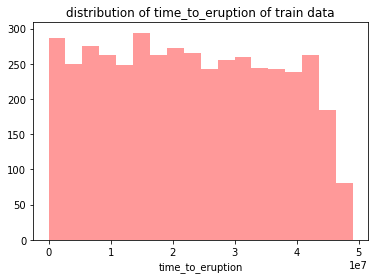

In [17]:
g = sns.distplot(train["time_to_eruption"],  kde=False, rug=False, color="r")
g.set_title("distribution of time_to_eruption of train data")

The value of time_to_eruption seems to be about the same number of times. The number decrease at 4e7 and above.

## Sensor data

To simple visualize, first, I check segment id 379022420 data. For line plots and other plots that cannot be written for 10 sensors at a time, I made the function myself. Some of the dataframes are re-read, but I just prioritized ease of processing, so don't worry about it.

### Line plot of each sensor data.

In [18]:
def crete_lineplot(segment_id):
    df = pd.read_csv(f"../input/predict-volcanic-eruptions-ingv-oe/train/{segment_id}.csv")    
    graphs = []

    for i in range(0, 9 , 5):
        idxs = list(np.array([0, 1, 2, 3, 4]) + i)

        fig, axs = plt.subplots(1, 5, sharey=True)
        for k, item in enumerate(idxs):
            g = sns.lineplot(data=df[f"sensor_{item+1}"], ax=axs[k], color="g")
            g.set_title(f"sensor: {item+1}")
            g.set(ylim=(-10000, 10000))
            graphs.append(g)

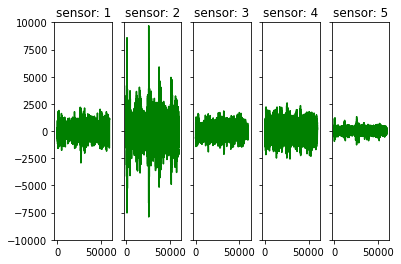

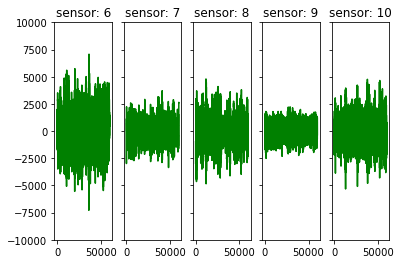

In [19]:
crete_lineplot(379022420)

We can see that the value of the second sensor in particular fluctuates greatly.

Other graphs are seems to be quiet.

### Boxplot of each sensor data.

I think detecting outliers will be important, so I'll also write a box-beard diagram.

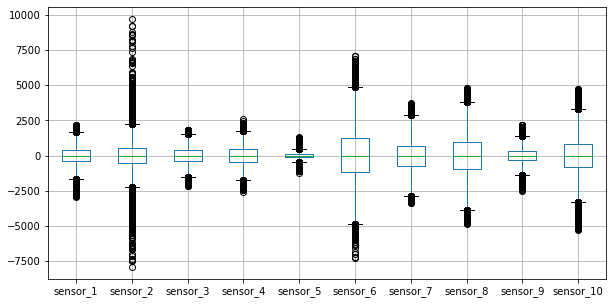

In [20]:
fig = plt.figure(figsize=(10, 5))
df_379022420 = pd.read_csv(f"../input/predict-volcanic-eruptions-ingv-oe/train/379022420.csv") 
boxplot = df_379022420.boxplot(column=[f'sensor_{i}' for i in range(1,11)])

### Violinplot of each sensor data.

I also create violinplot. For plot, I create function we can let data tidy.

In [21]:
def tidying_df(df):
    df_tidying = pd.DataFrame(columns=["value", "sensor"])

    for i in range(1, (df_379022420.shape[1]+1) ):
        df_sensor = df_379022420[[f"sensor_{i}"]].copy()
        df_sensor.columns = ["value"]
        df_sensor["sensor"] = f"sensor_{i}"
    
        df_tidying = pd.concat([df_tidying, df_sensor], axis=0, ignore_index=True)

    return df_tidying

In [22]:
df_379022420_tidy = tidying_df(df_379022420)

In [23]:
df_379022420_tidy.head()

value    sensor
0  290.0  sensor_1
1  318.0  sensor_1
2  292.0  sensor_1
3  262.0  sensor_1
4  197.0  sensor_1

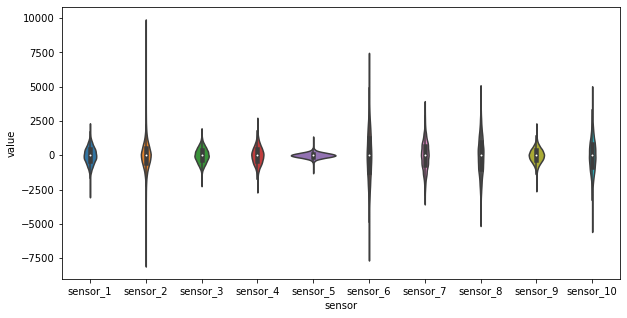

In [24]:
fig = plt.figure(figsize=(10, 5))
sns.violinplot(data=df_379022420_tidy, x="sensor" , y="value")

### Distplot of each sensor data.

I'll plot distplot of each sensor data. First, I create crete_distplot in convenience.

In [25]:
train[train["segment_id"] == 379022420]

segment_id  time_to_eruption
3189   379022420          30272738

In [26]:
def crete_distplot(segment_id):
    df = pd.read_csv(f"../input/predict-volcanic-eruptions-ingv-oe/train/{segment_id}.csv")    
    graphs = []

    for i in range(0, 9 , 5):
        idxs = list(np.array([0, 1, 2, 3, 4]) + i)

        fig, axs = plt.subplots(1, 5, sharey=True)
        for k, item in enumerate(idxs):
            g = sns.distplot(df[f"sensor_{item+1}"], ax=axs[k], color="y")
            g.set_title(f"sensor: {item+1}")
            g.set(ylim=(0, 0.0025))
            graphs.append(g)

The plots seems to be a left-right target. The average seems to be zero. Variance seems to be different by sensors.

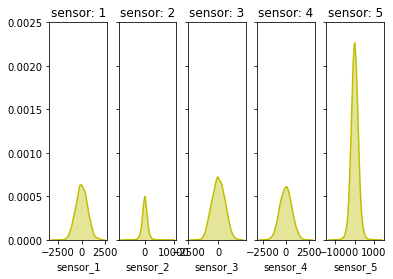

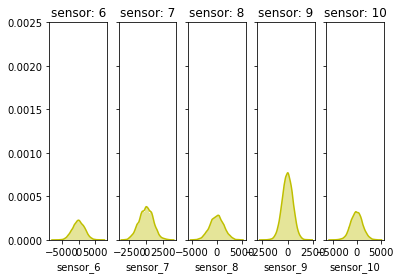

In [27]:
crete_distplot(379022420)

### pair plot of each sensor data.

Next, I plot pair plot. There doesn't seem to be any similarities in trends between the sensor data.

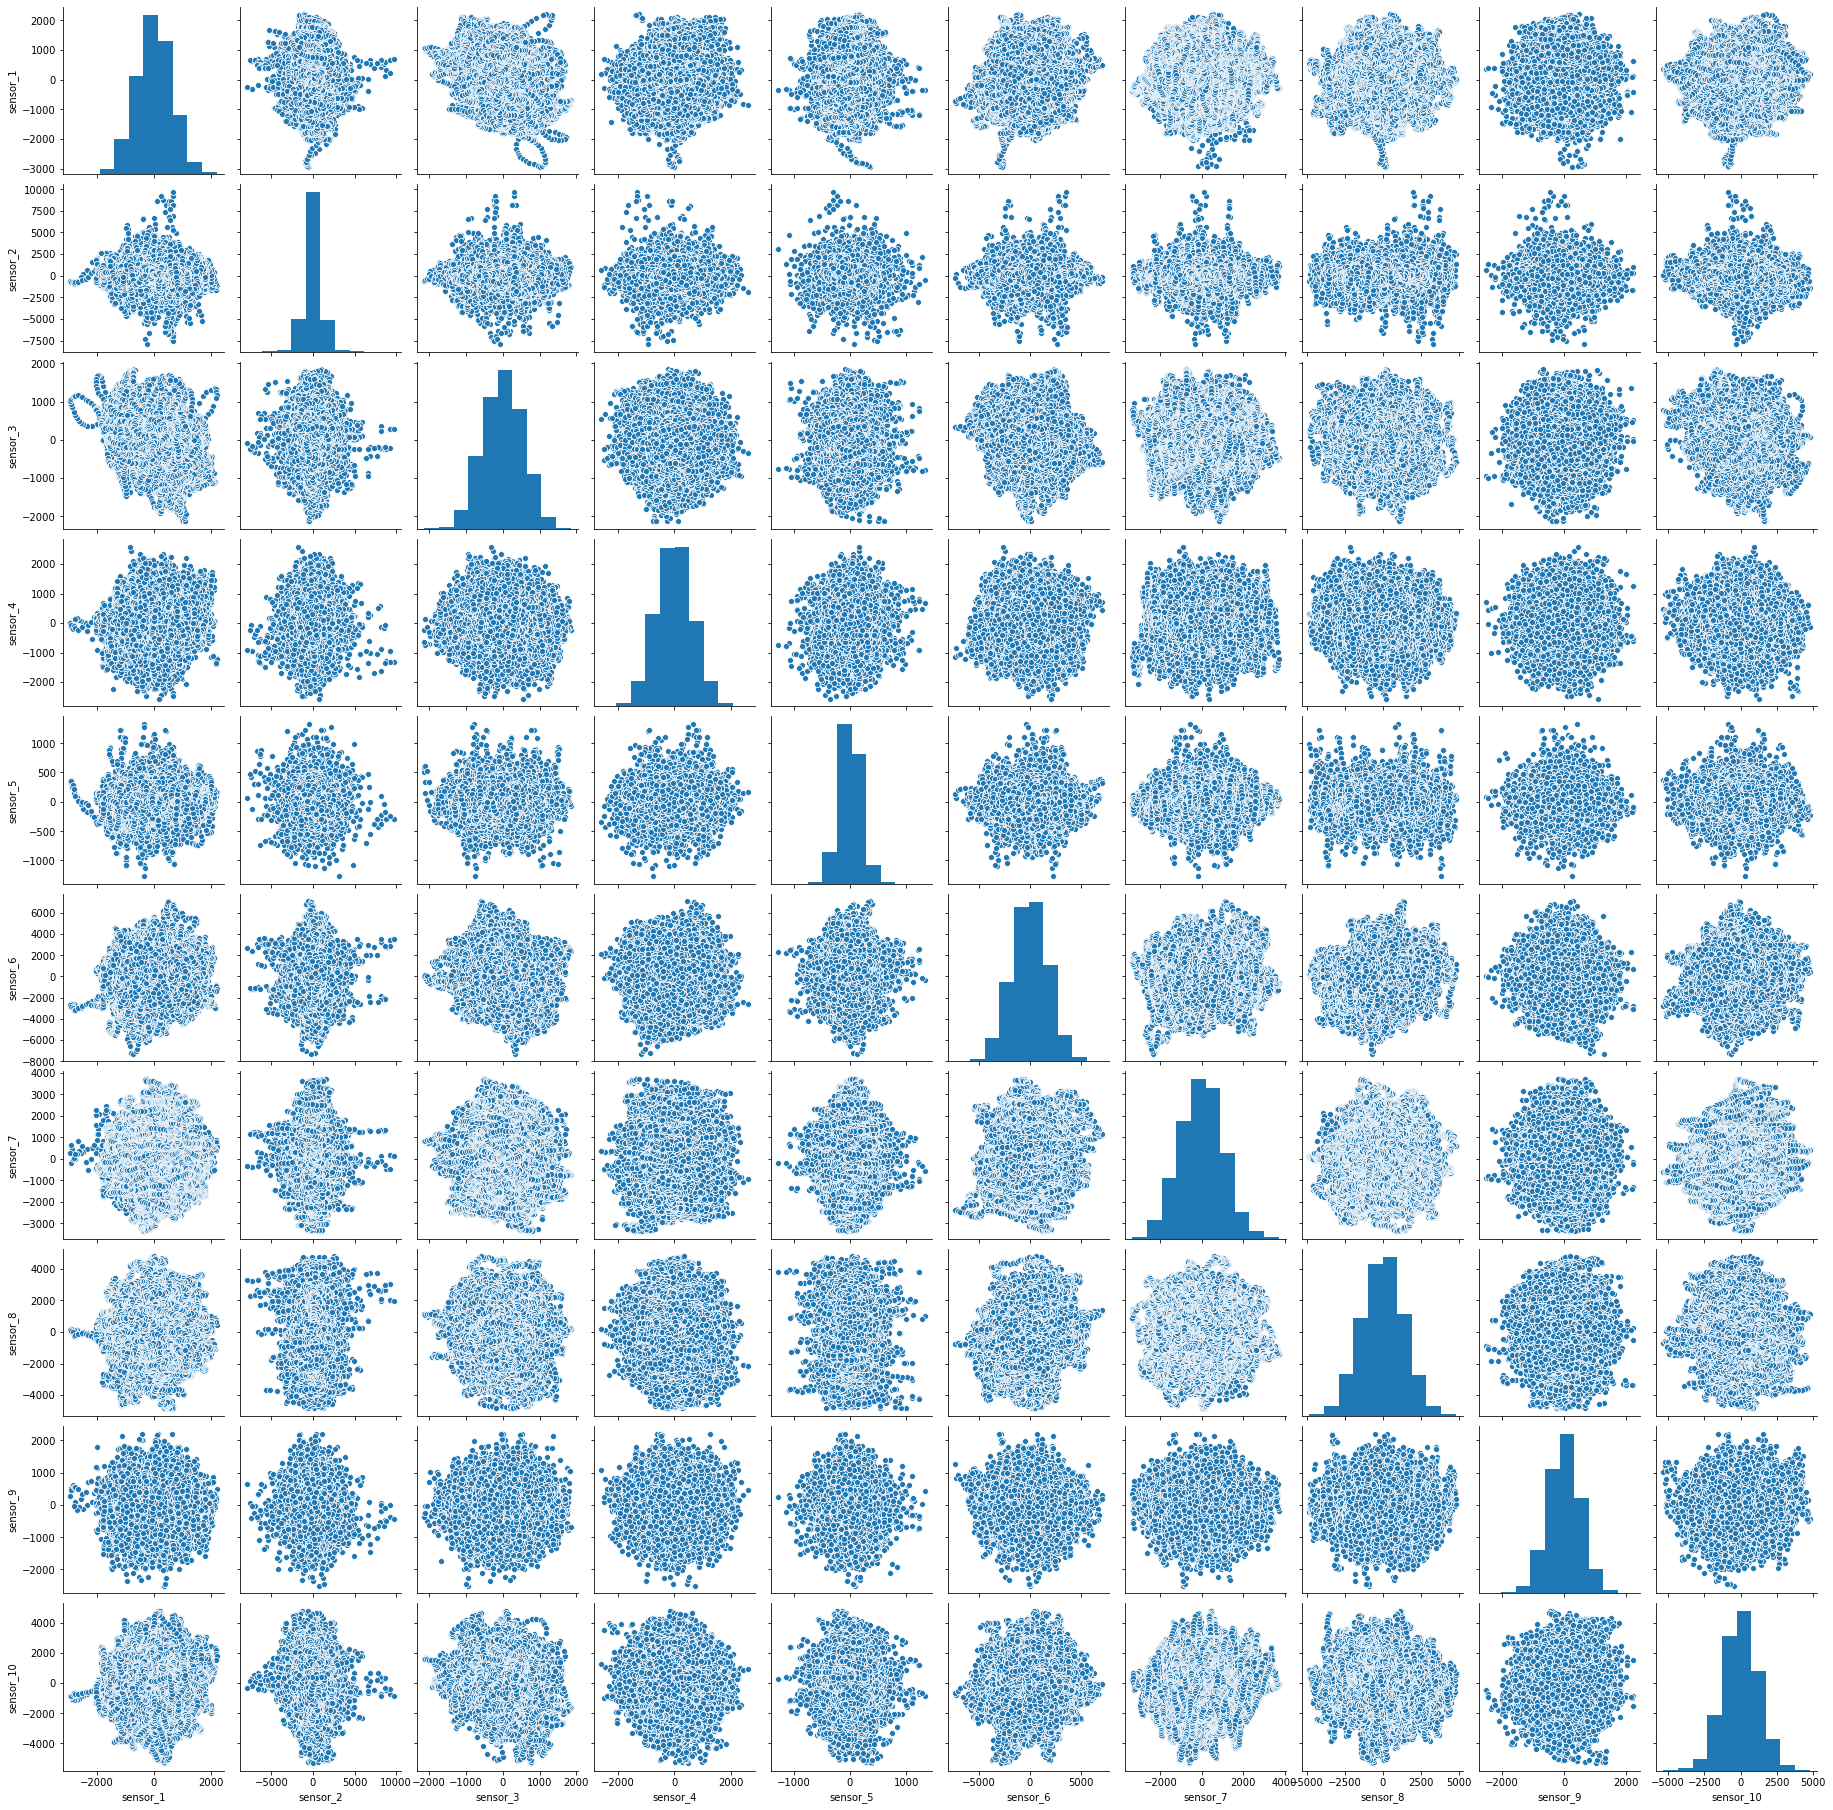

In [28]:
sns.pairplot(df_379022420)

### question

Data which time_to_eruption is smaller than 60000 represents eruption in it's value and graph?

In [29]:
train[train["time_to_eruption"] < 60000]

segment_id  time_to_eruption
413    442994108             28696
590    601524801              6250
1145  1957235969             26929
1291   765529516             58525
1724  1626437563             40492
2709  1658693785             25730
3942   775594946             52074

I create new function which can plot lineplot with supplementary wire. 

In [30]:
def crete_lineplot_with_supplementarywire(segment_id, xs):
    df = pd.read_csv(f"../input/predict-volcanic-eruptions-ingv-oe/train/{segment_id}.csv")    
    graphs = []

    for i in range(0, 9 , 5):
        idxs = list(np.array([0, 1, 2, 3, 4]) + i)

        fig, axs = plt.subplots(1, 5, sharey=True)
        for k, item in enumerate(idxs):
            g = sns.lineplot(data=df[f"sensor_{item+1}"], ax=axs[k])
            
            for supplementarywire_x in xs:
                axs[k].plot([supplementarywire_x, supplementarywire_x], [-10000, 10000], c='r', ls='--')
            g.set_title(f"sensor: {item+1}")
            g.set(ylim=(-10000, 10000))
            graphs.append(g)

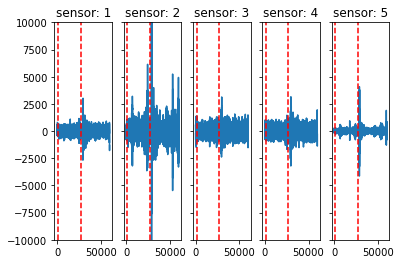

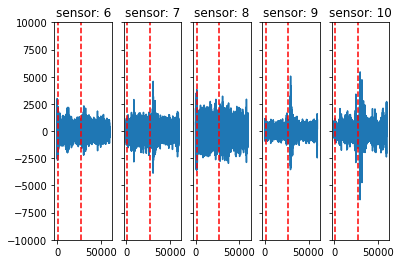

In [31]:
crete_lineplot_with_supplementarywire(1658693785, [1300, 27000])

Huuum.... It doesn't look so bad when we say there are signals at 250 second intervals...

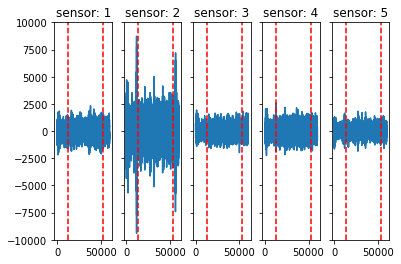

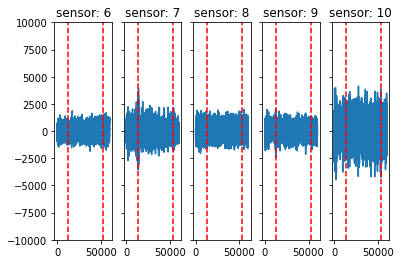

In [32]:
crete_lineplot_with_supplementarywire(1626437563, [13000, 53000])

The supplementary line on sensor2 looks like good...

<a id="5"></a> <br>
# <div class="alert alert-block alert-info">EDA</div>

Here, let's search trends for good represents time until the next eruption.

## Relation between time_to_eruption and descriptive statistics value

I tried to plot relation between time_to_eruption and following descriptive statistics values.

- max

- minimum

- mean

- variance

- 75, 95 and 99 percentiles

- count of outliners

This is because, we can guess that there might be some signs in 10 minutes sensor datas before eruption. If we found that in descriptive statistics value of sensor datas, we can use them for good prediction.

### Preparation.

I'll calculate above values for each train data.

In [33]:
def count_outlier(df, j):
    q1 = np.percentile(df[f"sensor_{j}"], 25, axis=0)
    q3 = np.percentile(df[f"sensor_{j}"], 75, axis=0)
    
    max = 2.5*q3 - 1.5*q1
    min = -0.5*q3 - 1.5*q1
    
    return (len(df[f"sensor_{j}"][df[f"sensor_{j}"]  > max] + len(df[f"sensor_{j}"][df[f"sensor_{j}"]  < min])))

In [34]:
!ls ../input/ingv-sensor-processed

train_preprocessed.csv


In [35]:
#for i, segment_id in tqdm(enumerate(train["segment_id"])):
#    df_segment_id = pd.read_csv(f"../input/predict-volcanic-eruptions-ingv-oe/train/{segment_id}.csv").fillna(0)
#    
#    for j in range(10):
#        train.loc[i, f"sensor_{j+1}_max"] = np.max(df_segment_id.fillna(0), axis=0)[j]
#        train.loc[i, f"sensor_{j+1}_min"] = np.min(df_segment_id.fillna(0), axis=0)[j]
#        train.loc[i, f"sensor_{j+1}_mean"] = np.mean(df_segment_id.fillna(0), axis=0)[j]
#        train.loc[i, f"sensor_{j+1}_var"] = np.var(df_segment_id.fillna(0), axis=0)[j]
#        train.loc[i, f"sensor_{j+1}_75_percentile"] = np.percentile(df_segment_id, 75, axis=0)[j]
#        train.loc[i, f"sensor_{j+1}_95_percentile"] = np.percentile(df_segment_id, 95, axis=0)[j]
#        train.loc[i, f"sensor_{j+1}_99_percentile"] = np.percentile(df_segment_id, 99, axis=0)[j]
#        train.loc[i, f"sensor_{j+1}_outlier"] = count_outlier(df_segment_id, j+1)
#        train.loc[i, f"sensor_{j+1}_null"] = 1 if df_segment_id.isnull().any()[j] else 0

#To save memory, I use processed data in my other notebook. 
#If you want to reproduce data processing, remove above comment outs
train = pd.read_csv("../input/ingv-sensor-processed/train_preprocessed.csv")

In [36]:
train.head()

segment_id  time_to_eruption  sensor_1_max  sensor_1_min  sensor_1_mean  \
0  1136037770          12262005        1353.0       -1421.0      -1.610323   
1  1969647810          32739612        2197.0       -2005.0       1.426126   
2  1895879680          14965999        1148.0       -1115.0       2.504592   
3  2068207140          26469720        1254.0       -1025.0       2.165797   
4   192955606          31072429        1114.0       -1190.0       0.073815   

    sensor_1_var  sensor_1_75_percentile  sensor_1_95_percentile  \
0   91865.714004                   199.0                   492.0   
1  192156.777800                   270.0                   704.0   
2   58357.708421                   157.0                   392.0   
3   49268.894229                   140.0                   361.0   
4   68483.621241                   170.0                   435.0   

   sensor_1_99_percentile  sensor_1_outlier  ...  sensor_9_null  \
0                   704.0             251.0  ...            0.0   
1                  1108.0             697.0  ...            1.0   
2                   613.0             522.0  ...            0.0   
3                   556.0             606.0  ...            1.0   
4                   636.0             343.0  ...            0.0   

   sensor_10_max  sensor_10_min  sensor_10_mean  sensor_10_var  \
0         2187.0        -3527.0        2.599440  356242.867235   
1         5319.0        -4591.0       19.895518  869914.160364   
2         2522.0        -2798.0        0.968101  250541.012899   
3         3614.0        -2911.0        8.381444  273995.171962   
4         3274.0        -2611.0       -3.740471  316680.389570   

   sensor_10_75_percentile  sensor_10_95_percentile  sensor_10_99_percentile  \
0                    410.0                    992.0                   1375.0   
1                    565.0                   1549.0                   2494.0   
2                    321.0                    822.0                   1231.0   
3                    326.0                    869.0                   1339.0   
4                    361.0                    915.0                   1334.0   

   sensor_10_outlier  sensor_10_null  
0              130.0             0.0  
1              917.0             0.0  
2              470.0             0.0  
3              686.0             0.0  
4              368.0             0.0  

[5 rows x 92 columns]

Also I create 2 functions to be able to visualize it all at once. I'll define these functions in following 2 cell and hide them. If you want to see them, please open the cells.

In [37]:
def plot_with_plotly(df, value):
    """value: max, min, mean or var"""
    fig = make_subplots(rows=5, cols=2)

    fig.append_trace(go.Scatter(
        x=df[f"sensor_1_{value}"],
        y=df["time_to_eruption"],
        name=f"sensor_1_{value}",
        mode="markers"
    ), row=1, col=1)

    fig.append_trace(go.Scatter(
        x=df[f"sensor_2_{value}"],
        y=df["time_to_eruption"],
        name=f"sensor_2_{value}",
        mode="markers"
    ), row=1, col=2)

    fig.append_trace(go.Scatter(
        x=df[f"sensor_3_{value}"],
        y=df["time_to_eruption"],
        name=f"sensor_3_{value}",
        mode="markers"
    ), row=2, col=1)

    fig.append_trace(go.Scatter(
        x=df[f"sensor_4_{value}"],
        y=df["time_to_eruption"],
        name=f"sensor_4_{value}",
        mode="markers"
    ), row=2, col=2)

    fig.append_trace(go.Scatter(
        x=df[f"sensor_5_{value}"],
        y=df["time_to_eruption"],
        name=f"sensor_5_{value}",
        mode="markers"
    ), row=3, col=1)

    fig.append_trace(go.Scatter(
        x=df[f"sensor_6_{value}"],
        y=df["time_to_eruption"],
        name=f"sensor_6_{value}",
        mode="markers"
    ), row=3, col=2)

    fig.append_trace(go.Scatter(
        x=df[f"sensor_7_{value}"],
        y=df["time_to_eruption"],
        name=f"sensor_7_{value}",
        mode="markers"
    ), row=4, col=1)

    fig.append_trace(go.Scatter(
        x=df[f"sensor_8_{value}"],
        y=df["time_to_eruption"],
        name=f"sensor_8_{value}",
        mode="markers"
    ), row=4, col=2)

    fig.append_trace(go.Scatter(
        x=df[f"sensor_9_{value}"],
        y=df["time_to_eruption"],
        name=f"sensor_9_{value}",
        mode="markers"
    ), row=5, col=1)

    fig.append_trace(go.Scatter(
        x=df[f"sensor_10_{value}"],
        y=df["time_to_eruption"],
        name=f"sensor_10_{value}",
        mode="markers"
    ), row=5, col=2)

    fig.update_layout(height=600, width=600, title_text=f"({value} of each sensor data) vs (time_to_eruption)")
    fig.show()

In [38]:
def plot_with_seaborn(df, value):
    """value: max, min, mean or var"""
    fig, axes = plt.subplots(5, 2, figsize=(10,20))
    fig.suptitle(f"({value} of each sensor data) vs (time_to_eruption)")
    g1 = sns.scatterplot(ax=axes[0, 0], data=df, x=df[f"sensor_1_{value}"], y=df["time_to_eruption"], color='orange')
    g2 = sns.scatterplot(ax=axes[0, 1], data=df, x=df[f"sensor_2_{value}"], y=df["time_to_eruption"], color='darkgoldenrod')
    g3 = sns.scatterplot(ax=axes[1, 0], data=df, x=df[f"sensor_3_{value}"], y=df["time_to_eruption"], color='darkkhaki')
    g4 = sns.scatterplot(ax=axes[1, 1], data=df, x=df[f"sensor_4_{value}"], y=df["time_to_eruption"], color='olive')
    g5 = sns.scatterplot(ax=axes[2, 0], data=df, x=df[f"sensor_5_{value}"], y=df["time_to_eruption"], color='lime')
    g6 = sns.scatterplot(ax=axes[2, 1], data=df, x=df[f"sensor_6_{value}"], y=df["time_to_eruption"], color='green')
    g7 = sns.scatterplot(ax=axes[3, 0], data=df, x=df[f"sensor_7_{value}"], y=df["time_to_eruption"], color='darkturquoise')
    g8 = sns.scatterplot(ax=axes[3, 1], data=df, x=df[f"sensor_8_{value}"], y=df["time_to_eruption"], color='blue')
    g9 = sns.scatterplot(ax=axes[4, 0], data=df, x=df[f"sensor_9_{value}"], y=df["time_to_eruption"], color='violet')
    g10 = sns.scatterplot(ax=axes[4, 1], data=df, x=df[f"sensor_10_{value}"], y=df["time_to_eruption"], color='darkmagenta')
    
    
    #fig.update_layout(height=600, width=600, title_text=f"({value} of each sensor data) vs (time_to_eruption)")
    fig.show()

### Trends between max of each sensor data and time_to_eruption.

Let's check trends between max of each sensor data and time_to_eruption. Until time_to_eruption ~ 1e7, some sensor data has large max. We might predict this area.

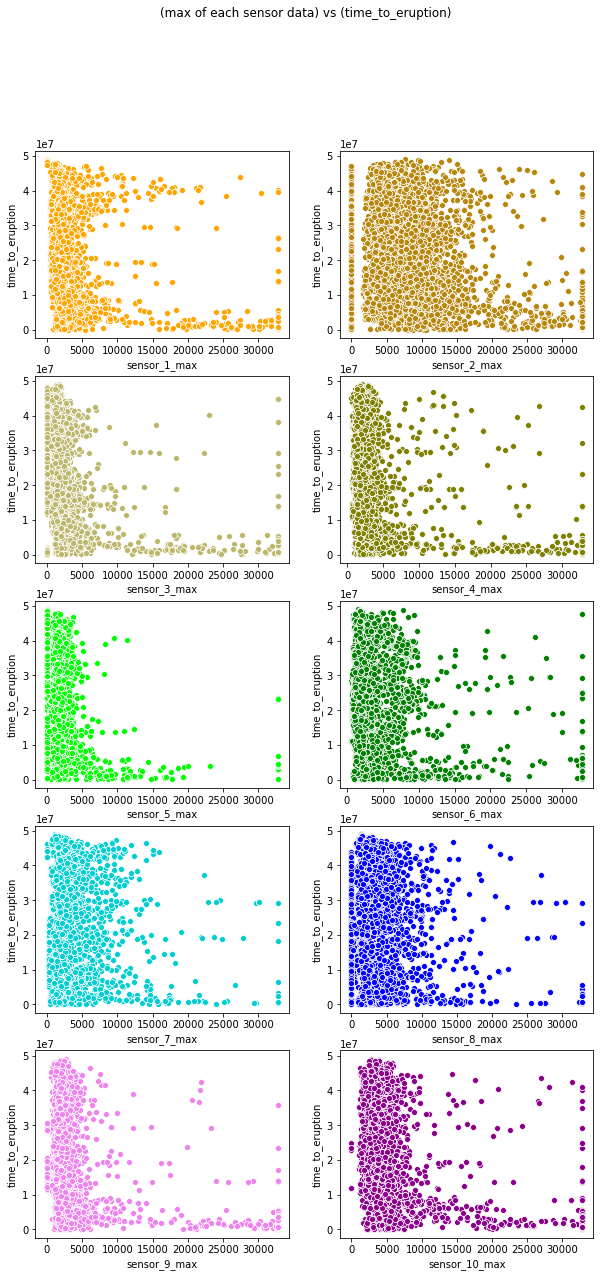

In [39]:
#If you want intaractive plot, use,
#plot_with_plotly(train, "max")

plot_with_seaborn(train, "max")



Most of the values are below a certain value (depending on the number of sensors), which from this point of view makes the predictions look difficult in this area.

The same is true when averaged across sensors.

Text(0.5, 1.0, 'mean of max of each sensor data in each segment vs time_to_eruption')

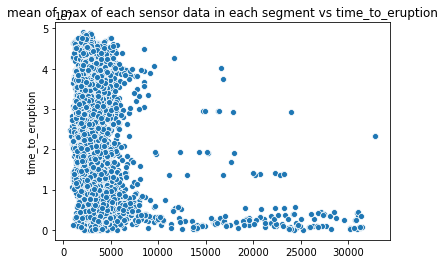

In [40]:
g_max_mean = sns.scatterplot(x=np.mean(train[[f"sensor_{i}_max" for i in range(1, 11)]], axis=1),
                             y=train["time_to_eruption"])
g_max_mean.set_title("mean of max of each sensor data in each segment vs time_to_eruption")

### Trends between minimum of each sensor data and time_to_eruption.

Nex't we'll check trends between minimum of each sensor data and time_to_eruption. 

As with the maximum, until time_to_eruption ~ 1e7, some sensor data has large negative value. We might predict this area.

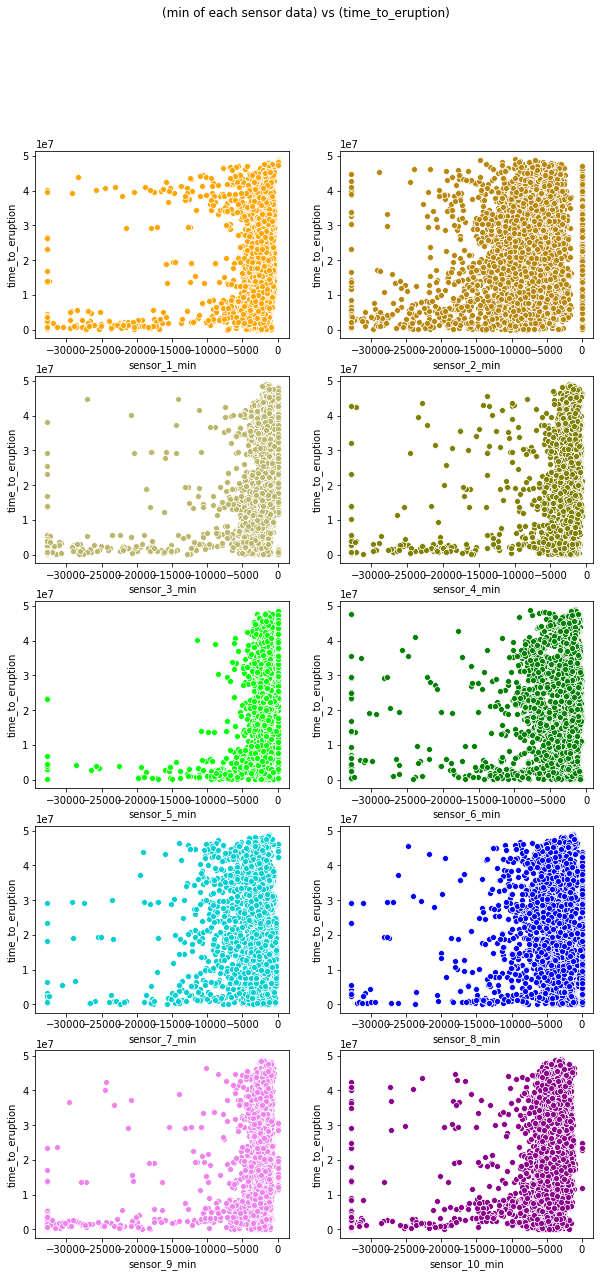

In [41]:
#If you want intaractive plot, use,
#plot_with_plotly(train, "min")

plot_with_seaborn(train, "min")

Most of the values are above a certain value (depending on the number of sensors), and from this point of view, the data in this area seems to be tricky to predict.

The same is true when averaged across sensors.

Text(0.5, 1.0, 'mean of minimum of each sensor data in each segment vs time_to_eruption')

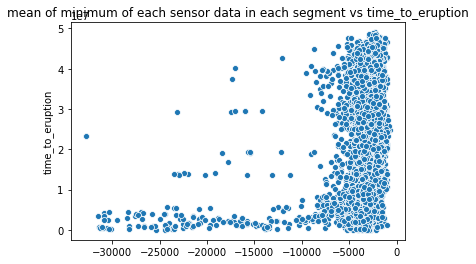

In [42]:
g_min_mean = sns.scatterplot(x=np.mean(train[[f"sensor_{i}_min" for i in range(1, 11)]], axis=1),
                             y=train["time_to_eruption"])
g_min_mean.set_title("mean of minimum of each sensor data in each segment vs time_to_eruption")

### Trends between mean of each sensor data and time_to_eruption.

Nex't we'll check trends between mean of each sensor data and time_to_eruption. 

Note that I filled NaN by 0, so there are some side effect.

Most of the values are clustered around 0. Rarely there seems to be data with a large mean. Also, there are many data with large mean for small time_to_eruption.

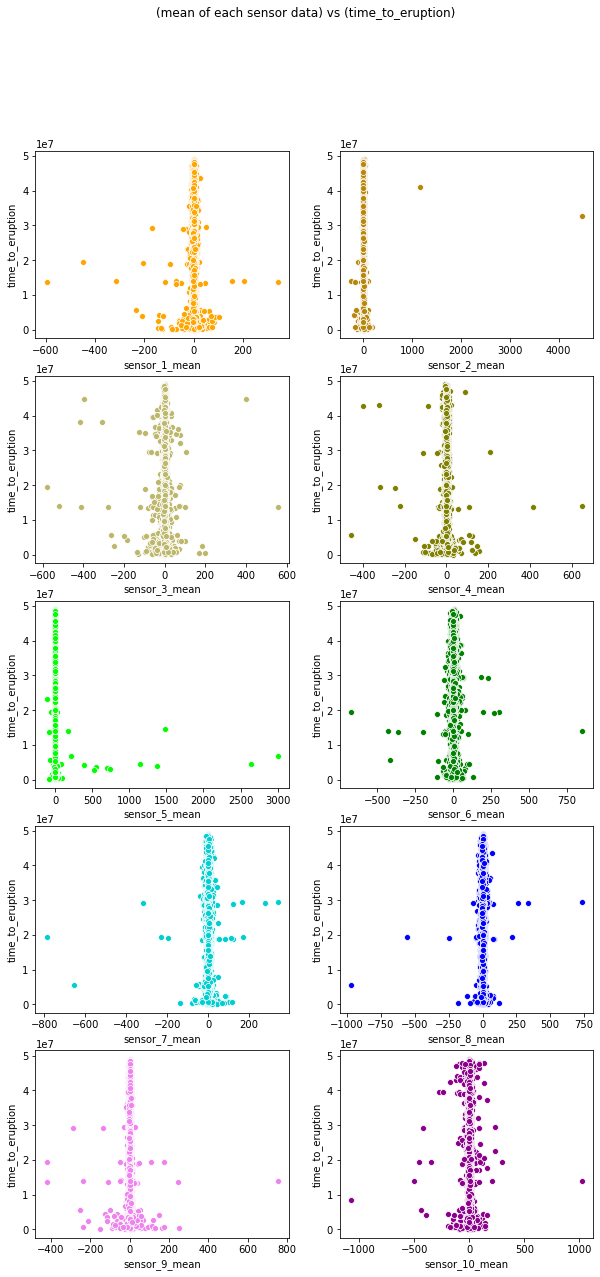

In [43]:
#If you want interactive plot, use,
#plot_with_plotly(train, "mean")

plot_with_seaborn(train, "mean")

If we get average across sensors, most values are near 0.

Text(0.5, 1.0, 'mean of mean of each sensor data in each segment vs time_to_eruption')

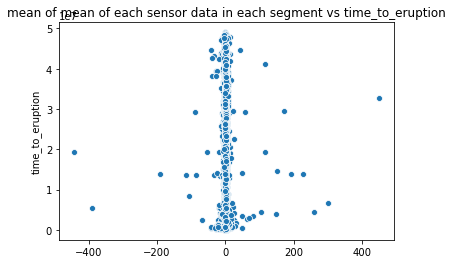

In [44]:
g_mean_mean = sns.scatterplot(x=np.mean(train[[f"sensor_{i}_mean" for i in range(1, 11)]], axis=1),
                             y=train["time_to_eruption"])
g_mean_mean.set_title("mean of mean of each sensor data in each segment vs time_to_eruption")

### Trends between variance of each sensor data and time_to_eruption.

Next we'll check trends between variance of each sensor data and time_to_eruption. 

For small time_to_eruption, we can see that there is a large variance. This trend is same as max and minimum, but it's more pronounced. 

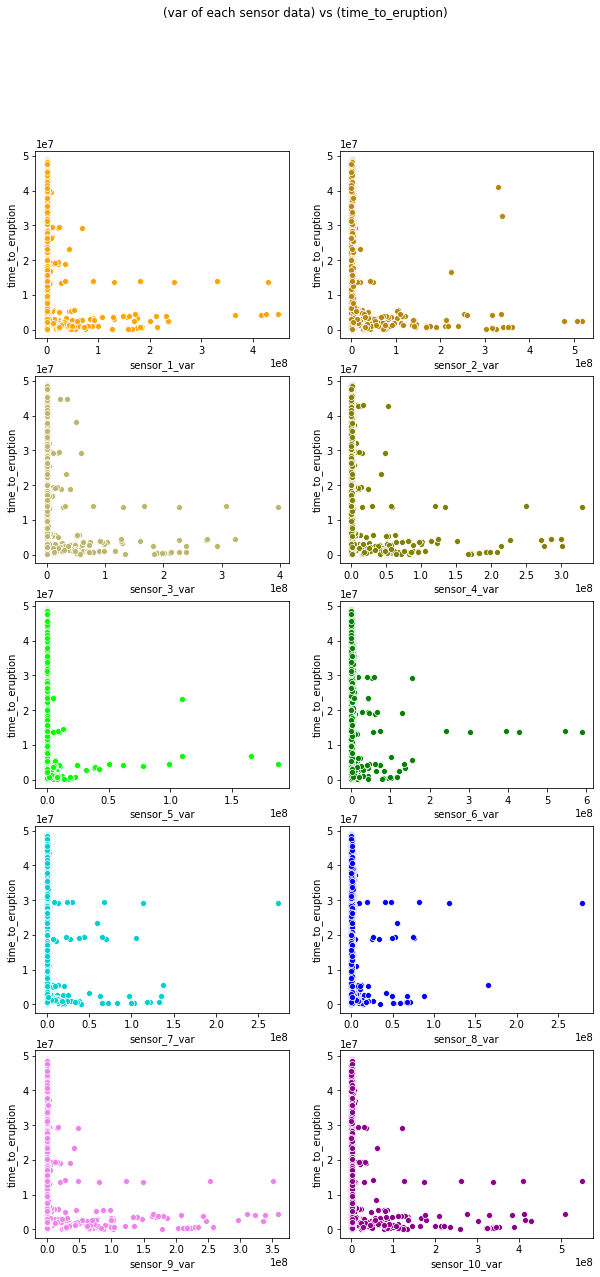

In [45]:
#If you want interactive plot, use,
#plot_with_plotly(train, "var")

plot_with_seaborn(train, "var")

Text(0.5, 1.0, 'mean of var of each sensor data in each segment vs time_to_eruption')

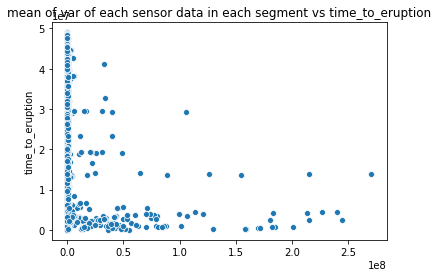

In [46]:
g_var_mean = sns.scatterplot(x=np.mean(train[[f"sensor_{i}_var" for i in range(1, 11)]], axis=1),
                             y=train["time_to_eruption"])
g_var_mean.set_title("mean of var of each sensor data in each segment vs time_to_eruption")

### Trends 75, 95 and 99 percentiles of each sensor data and time_to_eruption.

We'll check trends between 75, 95 and 99 percentiles of each sensor data and time_to_eruption. 

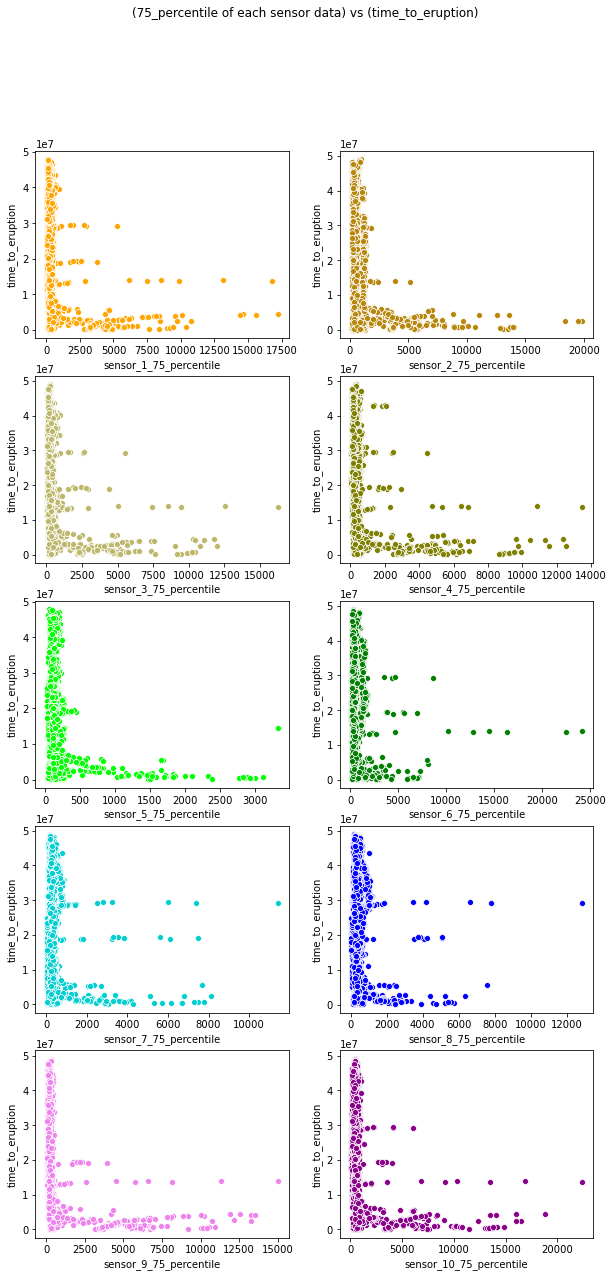

In [47]:
#If you want interactive plot, use,
#plot_with_plotly(train, "75_percentile")

plot_with_seaborn(train, "75_percentile")

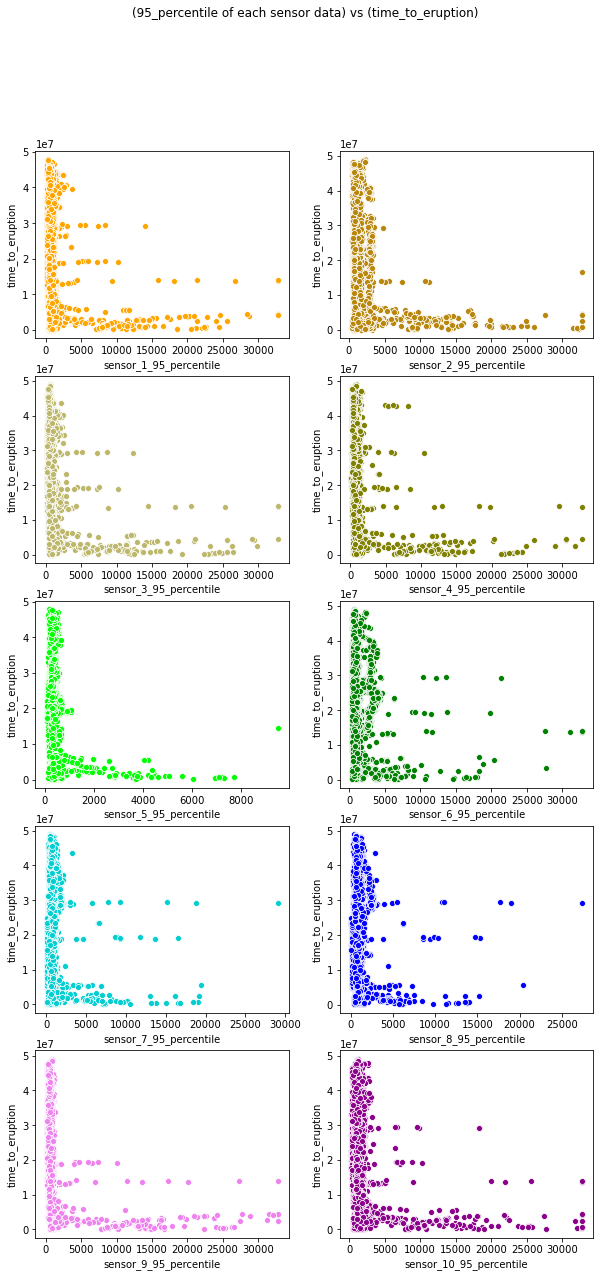

In [48]:
#If you want interactive plot, use,
#plot_with_plotly(train, "95_percentile")

plot_with_seaborn(train, "95_percentile")

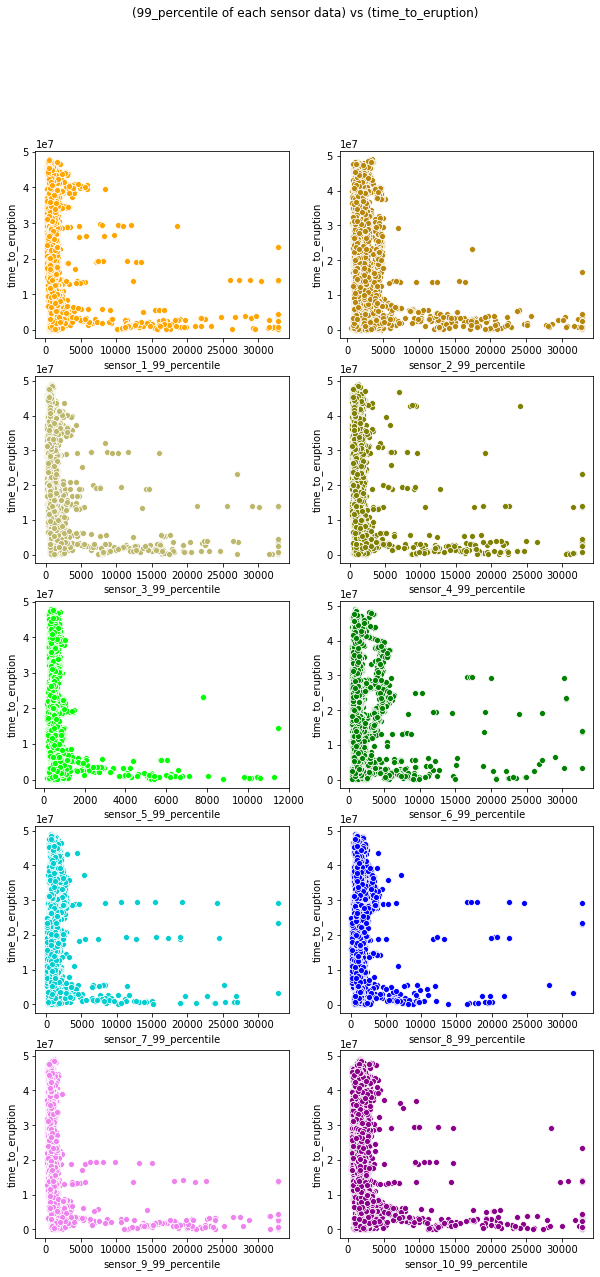

In [49]:
#If you want interactive plot, use,
#plot_with_plotly(train, "99_percentile")

plot_with_seaborn(train, "99_percentile")

Sensor 6, in particular, takes great value in 2 ~ 4 le7 time_to_eruption area.

### Trends between count of outlier of each sensor data and time_to_eruption.

Finaly, we'll check trends between count of outlier of each sensor data and time_to_eruption. 

Unlike the previous other values, we can see that the x-axis value is larger for large time_to_eruption. Also, for small time_to_eruption, the value of x-axis does not tend to be large. 

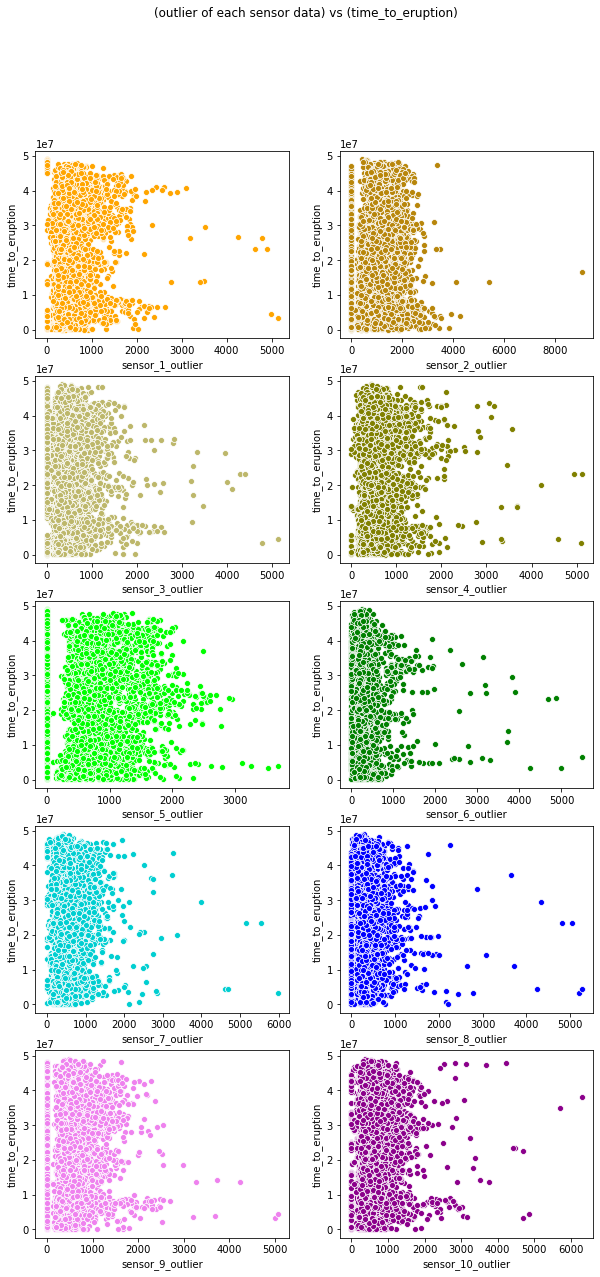

In [50]:
plot_with_seaborn(train, "outlier")

In particular, we can see that sensor9 has a distinctly different feature for large time_to_eruption than before. If there is time before the next eruption, the tremor should be smaller, so it may be easier to detect it as an outlier when big tremor occurs.

### Sensor down time.

I also processed whether or not each sensor was down in each segment. For the power supply, sensors have down time and then, data will be null. 

In my data process above, I convert 1 if there are null and 0 if there aren't.

Like this, 

> train.loc[i, f"sensor_{j+1}_null"] = 1 if df_segment_id.isnull().any()[j] else 0

In [51]:
def plot_with_seaborn_countplot(df, value):
    """null"""
    fig, axes = plt.subplots(5, 2, figsize=(10,20))
    fig.suptitle(f"({value} of each sensor data) vs (time_to_eruption)")
    g1 = sns.countplot(ax=axes[0, 0], data=df, x=df[f"sensor_1_{value}"],  color='orange')
    g2 = sns.countplot(ax=axes[0, 1], data=df, x=df[f"sensor_2_{value}"], color='darkgoldenrod')
    g3 = sns.countplot(ax=axes[1, 0], data=df, x=df[f"sensor_3_{value}"], color='darkkhaki')
    g4 = sns.countplot(ax=axes[1, 1], data=df, x=df[f"sensor_4_{value}"], color='olive')
    g5 = sns.countplot(ax=axes[2, 0], data=df, x=df[f"sensor_5_{value}"], color='lime')
    g6 = sns.countplot(ax=axes[2, 1], data=df, x=df[f"sensor_6_{value}"], color='green')
    g7 = sns.countplot(ax=axes[3, 0], data=df, x=df[f"sensor_7_{value}"], color='darkturquoise')
    g8 = sns.countplot(ax=axes[3, 1], data=df, x=df[f"sensor_8_{value}"], color='blue')
    g9 = sns.countplot(ax=axes[4, 0], data=df, x=df[f"sensor_9_{value}"], color='violet')
    g10 = sns.countplot(ax=axes[4, 1], data=df, x=df[f"sensor_10_{value}"], color='darkmagenta')
    
    
    #fig.update_layout(height=600, width=600, title_text=f"({value} of each sensor data) vs (time_to_eruption)")
    fig.show()

We can check down rate for each sensors by countplot.

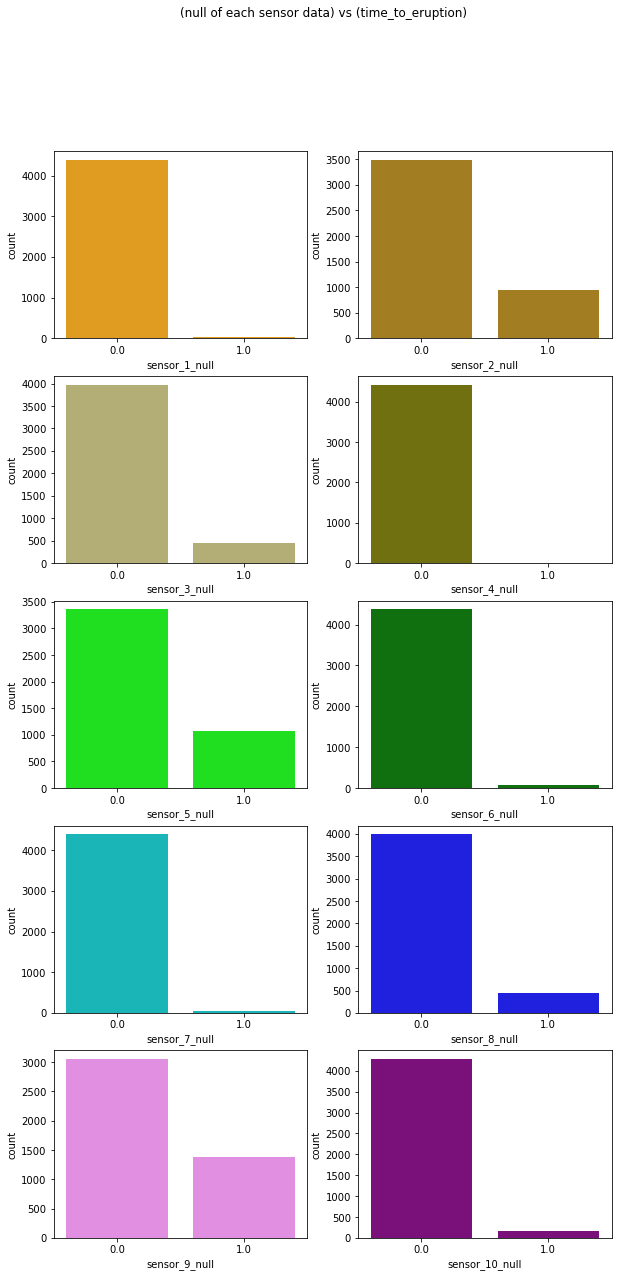

In [52]:
plot_with_seaborn_countplot(train, "null")

In particular, sensors 2, 5 and 9 often seem to be down. Sensors 1, 4 and 7 often seem to be rarely down.

In [53]:
train.to_csv('train_preprocessed.csv', index=False)

<a id="6"></a> <br>
# <div class="alert alert-block alert-info">Application to prediction</div>

Here, I apply count of outlier as feature for baseline notebook, and make sure it is improved.

For the baseline, I use @ajcostarino 's great notebook (https://www.kaggle.com/ajcostarino/ingv-volcanic-eruption-prediction-lgbm-baseline).

I improved lb score 6614776 -> 6555212.

In [54]:
import numpy as np

from sklearn.linear_model import LinearRegression
import scipy.stats as spstats


def basic_statistics(t_X, x, s, sensor, postfix=''):
    """Computes basic statistics for the training feature set.
    
    Args:
        t_X (pandas.DataFrame): The feature set being built.
        x (pandas.Series): The signal values.
        s (int): The integer number of the segment.
        postfix (str): The postfix string value.
    Return:
        t_X (pandas.DataFrame): The feature set being built.
    """

    t_X.loc[s, f'{sensor}_sum{postfix}']       = x.sum()
    t_X.loc[s, f'{sensor}_mean{postfix}']      = x.mean()
    t_X.loc[s, f'{sensor}_std{postfix}']       = x.std()
    t_X.loc[s, f'{sensor}_var{postfix}']       = x.var() 
    t_X.loc[s, f'{sensor}_max{postfix}']       = x.max()
    t_X.loc[s, f'{sensor}_min{postfix}']       = x.min()
    t_X.loc[s, f'{sensor}_median{postfix}']    = x.median()
    t_X.loc[s, f'{sensor}_skew{postfix}']      = x.skew()
    t_X.loc[s, f'{sensor}_mad{postfix}']       = x.mad()
    t_X.loc[s, f'{sensor}_kurtosis{postfix}']  = x.kurtosis()

    return t_X



def quantiles(t_X, x, s, sensor, postfix=''):
    """Calculates quantile features for the training feature set.
    Args:
        t_X (pandas.DataFrame): The feature set being built.
        x (pandas.Series): The signal values.
        s (int): The integer number of the segment.
        postfix (str): The postfix string value.
    Return:
        t_X (pandas.DataFrame): The feature set being built.
    """
    t_X.loc[s, f'{sensor}_q999{postfix}']     = np.quantile(x ,0.999)
    t_X.loc[s, f'{sensor}_q99{postfix}']      = np.quantile(x, 0.99)
    t_X.loc[s, f'{sensor}_q95{postfix}']      = np.quantile(x, 0.95)
    t_X.loc[s, f'{sensor}_q87{postfix}']      = np.quantile(x, 0.87)
    t_X.loc[s, f'{sensor}_q13{postfix}']      = np.quantile(x, 0.13)  
    t_X.loc[s, f'{sensor}_q05{postfix}']      = np.quantile(x, 0.05)
    t_X.loc[s, f'{sensor}_q01{postfix}']      = np.quantile(x, 0.01)
    t_X.loc[s, f'{sensor}_q001{postfix}']     = np.quantile(x ,0.001)
    
    x_abs = np.abs(x)
    t_X.loc[s, f'{sensor}_q999_abs{postfix}'] = np.quantile(x_abs, 0.999)
    t_X.loc[s, f'{sensor}_q99_abs{postfix}']  = np.quantile(x_abs, 0.99)
    t_X.loc[s, f'{sensor}_q95_abs{postfix}']  = np.quantile(x_abs, 0.95)
    t_X.loc[s, f'{sensor}_q87_abs{postfix}']  = np.quantile(x_abs, 0.87)
    t_X.loc[s, f'{sensor}_q13_abs{postfix}']  = np.quantile(x_abs, 0.13)
    t_X.loc[s, f'{sensor}_q05_abs{postfix}']  = np.quantile(x_abs, 0.05)
    t_X.loc[s, f'{sensor}_q01_abs{postfix}']  = np.quantile(x_abs, 0.01)
    t_X.loc[s, f'{sensor}_q001_abs{postfix}'] = np.quantile(x_abs, 0.001)
    
    t_X.loc[s, f'{sensor}_iqr']     = np.subtract(*np.percentile(x, [75, 25]))
    t_X.loc[s, f'{sensor}_iqr_abs'] = np.subtract(*np.percentile(x_abs, [75, 25]))

    return t_X


def __linear_regression(arr, abs_v=False):
    """
    """
    idx = np.array(range(len(arr)))
    if abs_v:
        arr = np.abs(arr)
    lr = LinearRegression()
    fit_X = idx.reshape(-1, 1)
    lr.fit(fit_X, arr)
    return lr.coef_[0]


def __classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta


def linear_regression(t_X, x, s, sensor, postfix=''):
    t_X.loc[s, f'{sensor}_lr_coef{postfix}'] = __linear_regression(x)
    t_X.loc[s, f'{sensor}_lr_coef_abs{postfix}'] = __linear_regression(x, True)
    return t_X


def classic_sta_lta(t_X, x, sensor, s):
    t_X.loc[s, f'{sensor}_classic_sta_lta1_mean'] = __classic_sta_lta(x, 500, 10000).mean()
    t_X.loc[s, f'{sensor}_classic_sta_lta2_mean'] = __classic_sta_lta(x, 5000, 100000).mean()
    t_X.loc[s, f'{sensor}_classic_sta_lta3_mean'] = __classic_sta_lta(x, 3333, 6666).mean()
    t_X.loc[s, f'{sensor}_classic_sta_lta4_mean'] = __classic_sta_lta(x, 10000, 25000).mean()
    return t_X


def fft(t_X, x, s, sensor, postfix=''):
    """Generates basic statistics over the fft of the signal"""
    z = np.fft.fft(x)
    fft_real = np.real(z)
    fft_imag = np.imag(z)

    t_X.loc[s, f'fft_A0']             = abs(z[0])
    
    t_X.loc[s, f'{sensor}_fft_real_mean{postfix}']      = fft_real.mean()
    t_X.loc[s, f'{sensor}_fft_real_std{postfix}']       = fft_real.std()
    t_X.loc[s, f'{sensor}_fft_real_max{postfix}']       = fft_real.max()
    t_X.loc[s, f'{sensor}_fft_real_min{postfix}']       = fft_real.min()
    t_X.loc[s, f'{sensor}_fft_real_median{postfix}']    = np.median(fft_real)
    t_X.loc[s, f'{sensor}_fft_real_skew{postfix}']      = spstats.skew(fft_real)
    t_X.loc[s, f'{sensor}_fft_real_kurtosis{postfix}']  = spstats.kurtosis(fft_real)
    
    t_X.loc[s, f'{sensor}_fft_imag_mean{postfix}']      = fft_imag.mean()
    t_X.loc[s, f'{sensor}_fft_imag_std{postfix}']       = fft_imag.std()
    t_X.loc[s, f'{sensor}_fft_imag_max{postfix}']       = fft_imag.max()
    t_X.loc[s, f'{sensor}_fft_imag_min{postfix}']       = fft_imag.min()
    t_X.loc[s, f'{sensor}_fft_imag_median{postfix}']    = np.median(fft_imag)
    t_X.loc[s, f'{sensor}_fft_imag_skew{postfix}']      = spstats.skew(fft_imag)
    t_X.loc[s, f'{sensor}_fft_imag_kurtosis{postfix}']  = spstats.kurtosis(fft_imag)
    
    return t_X

## In this kernel I add count of outlier here. ↓↓↓

In [55]:
def count_outlier(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    
    max = 2.5*q3 - 1.5*q1
    min = -0.5*q3 - 1.5*q1
    
    return (len(x[x  > max] + len(x[x  < min])))

def outlier(t_X, x, s, sensor, postfix=''):
    t_X.loc[s, f'{sensor}_outlier{postfix}'] = count_outlier(x)
    return t_X

### <div class="alert alert-block alert-warning">In this notebook, I set up not to train and predict. If you want to do so, please set "training_and_pred" to True.</div>

In [56]:
training_and_pred = False

In [57]:
if training_and_pred:
    train = pd.read_csv('/kaggle/input/predict-volcanic-eruptions-ingv-oe/train.csv')
    train_set = pd.DataFrame()
    train_set['segment_id'] = train.segment_id
    train_set = train_set.set_index('segment_id')

    j = 0
    for seg in train.segment_id:
        signals = pd.read_csv(f'/kaggle/input/predict-volcanic-eruptions-ingv-oe/train/{seg}.csv')
        for i in range(1, 11):
            sensor_id = f'sensor_{i}'
            train_set = basic_statistics(train_set, signals[sensor_id].fillna(0), seg, sensor_id, postfix='')
            train_set = quantiles(train_set, signals[sensor_id].fillna(0), seg, sensor_id, postfix='')
        
            ###Add this line
            train_set = outlier(train_set, signals[sensor_id].fillna(0), seg, sensor_id, postfix='')
        
            train_set = linear_regression(train_set, signals[sensor_id].fillna(0), seg, sensor_id, postfix='')
            train_set = fft(train_set, signals[sensor_id].fillna(0), seg, sensor_id, postfix='')
        
    train_set = pd.merge(train_set.reset_index(), train, on=['segment_id'], how='left').set_index('segment_id')
    
    
    test = pd.read_csv('/kaggle/input/predict-volcanic-eruptions-ingv-oe/sample_submission.csv')
    test_set = pd.DataFrame()
    test_set['segment_id'] = test.segment_id
    test_set = test_set.set_index('segment_id')


    for seg in test.segment_id:
        signals = pd.read_csv(f'/kaggle/input/predict-volcanic-eruptions-ingv-oe/test/{seg}.csv')
        for i in range(1, 11):
            sensor_id = f'sensor_{i}'
            test_set = basic_statistics(test_set, signals[sensor_id].fillna(0), seg, sensor_id, postfix='')
            test_set = quantiles(test_set, signals[sensor_id].fillna(0), seg, sensor_id, postfix='')
        
            ###Add this line
            test_set = outlier(test_set, signals[sensor_id].fillna(0), seg, sensor_id, postfix='')
        
            test_set = linear_regression(test_set, signals[sensor_id].fillna(0), seg, sensor_id, postfix='')
            test_set = fft(test_set, signals[sensor_id].fillna(0), seg, sensor_id, postfix='')

In [58]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold

if training_and_pred:

    y = train_set['time_to_eruption']
    feature_df = train_set.drop(['time_to_eruption'], axis = 1)

    scaler = StandardScaler()
    scaler.fit(feature_df)
    scaled_feature_df = pd.DataFrame(scaler.transform(feature_df), columns=feature_df.columns)
    scaled_test_df    = pd.DataFrame(scaler.transform(test_set), columns=test_set.columns)

    print(scaled_feature_df.shape)
    print(scaled_test_df.shape)


    n_fold = 5
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
    scaled_feature_df_columns = scaled_feature_df.columns.values


    params = {
        'num_leaves': 85,
        'min_data_in_leaf': 10, 
        'objective':'regression',
        'max_depth': -1,
        'learning_rate': 0.001,
        'max_bins': 2048,
        "boosting": "gbdt",
        "feature_fraction": 0.91,
        "bagging_freq": 1,
        "bagging_fraction": 0.91,
        "bagging_seed": 42,
        "metric": 'mae',
        "lambda_l1": 0.1,
        "verbosity": -1,
        "nthread": -1,
        "random_state": 42
    }


    oof = np.zeros(len(scaled_feature_df))
    predictions = np.zeros(len(scaled_test_df))
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_feature_df, y.values)):
    
        strLog = "fold {}".format(fold_)
        print(strLog)
    
        X_tr, X_val = scaled_feature_df.iloc[trn_idx], scaled_feature_df.iloc[val_idx]
        y_tr, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        model = lgbm.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
        model.fit(X_tr, y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
              verbose=1000, early_stopping_rounds=400)
    
        oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = scaled_feature_df_columns
        fold_importance_df["importance"] = model.feature_importances_[:len(scaled_feature_df_columns)]
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        #predictions
        predictions += model.predict(scaled_test_df, num_iteration=model.best_iteration_) / folds.n_splits
    
    
    submission = pd.DataFrame()
    submission['segment_id'] = test_set.index
    submission['time_to_eruption'] = predictions
    submission.to_csv('submission_recent.csv', header=True, index=False)    